In [1]:
import pandas as pd
df = pd.read_csv("c:/data/school/data.csv")
df.head()

,teaching,international,research,citations,income,num_students,student_staff_ratio,international_students,total_score,Label
0,12.4,95.6,10.6,13.3,33.3,5226,14.1,0.82,59.8,0
1,29.9,90.1,20.1,65.3,33.9,2473,15.6,0.63,59.8,0
2,24.7,82.6,18.9,43.5,28.4,2473,15.6,0.63,59.8,0
3,61.3,98.6,67.5,94.6,65.4,9666,10.5,0.54,76.1,1
4,62.4,98.8,57.0,95.0,49.8,9666,10.5,0.54,73.0,1


In [2]:
train_cols = df.columns[:-2]
X = df[train_cols] # 독립변수
y = df["Label"] # 종속변수

In [3]:
# 언더샘플링
from imblearn.under_sampling import RandomUnderSampler
X_sample, y_sample = RandomUnderSampler(random_state=0).fit_resample(X, y)
X_samp = pd.DataFrame(data=X_sample,columns=train_cols )
y_samp = pd.DataFrame(data=y_sample,columns=['Label'])
df_samp=pd.concat([X_samp,y_samp],axis=1)

In [4]:
df_samp["Label"].value_counts()

0    445
1    445
Name: Label, dtype: int64

In [5]:
X=df_samp[train_cols]
y=df_samp["Label"]

In [6]:
import statsmodels.api as sm
model=sm.Logit(y,X)
result=model.fit()
print(result.summary2())
# 모델의 설명력 62%
# citations 변수는 유의하지 않음

Optimization terminated successfully.
         Current function value: 0.263067
         Iterations 8
                            Results: Logit
Model:                Logit             Pseudo R-squared:  0.620      
Dependent Variable:   Label             AIC:               484.2592   
Date:                 2022-06-03 13:13  BIC:               522.5889   
No. Observations:     890               Log-Likelihood:    -234.13    
Df Model:             7                 LL-Null:           -616.90    
Df Residuals:         882               LLR p-value:       5.0478e-161
Converged:            1.0000            Scale:             1.0000     
No. Iterations:       8.0000                                          
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
teaching               -0.0665   0.0155 -4.2972 0.0000 -0.0969 -0.0362
int

In [8]:
# citations 변수를 제거한 모형
cols=['teaching', 'international', 'research', 'income', 'num_students', 'student_staff_ratio', 'international_students']
X=df_samp[cols]
model=sm.Logit(y,X)
result=model.fit()
print(result.summary2())
# 양의 상관관계: international_students 외국인학생수, research 연구능력
# 음의 상관관계: student_staff_ratio 교수 1인당 담당학생수가 적으면 우수한 학교

Optimization terminated successfully.
         Current function value: 0.263068
         Iterations 8
                            Results: Logit
Model:                Logit             Pseudo R-squared:  0.620      
Dependent Variable:   Label             AIC:               482.2606   
Date:                 2022-06-03 13:15  BIC:               515.7991   
No. Observations:     890               Log-Likelihood:    -234.13    
Df Model:             6                 LL-Null:           -616.90    
Df Residuals:         883               LLR p-value:       4.2846e-162
Converged:            1.0000            Scale:             1.0000     
No. Iterations:       8.0000                                          
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
teaching               -0.0668   0.0139 -4.8183 0.0000 -0.0940 -0.0396
int

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
pipe = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(random_state=0)),])
params = {
'clf__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100],
}
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

{'clf__C': 100}
0.9156770406770406


In [10]:
# 다양한 알고리즘별 정확도를 저장할 리스트
scores=[]

In [11]:
scores.append(grid.best_score_)
scores

[0.9156770406770406]

In [12]:
# 의사결정나무
from sklearn.tree import DecisionTreeClassifier
pipe = Pipeline([
    # 같은 조건으로 실행해야 함
('scaler', StandardScaler()), ('clf', DecisionTreeClassifier(random_state=0)),])
params = {
'clf__max_depth': list(range(3,6))
}
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

{'clf__max_depth': 3}
0.7817135317135318


In [13]:
scores.append(grid.best_score_)
scores

[0.9156770406770406, 0.7817135317135318]

In [14]:
tree=grid.best_estimator_['clf']

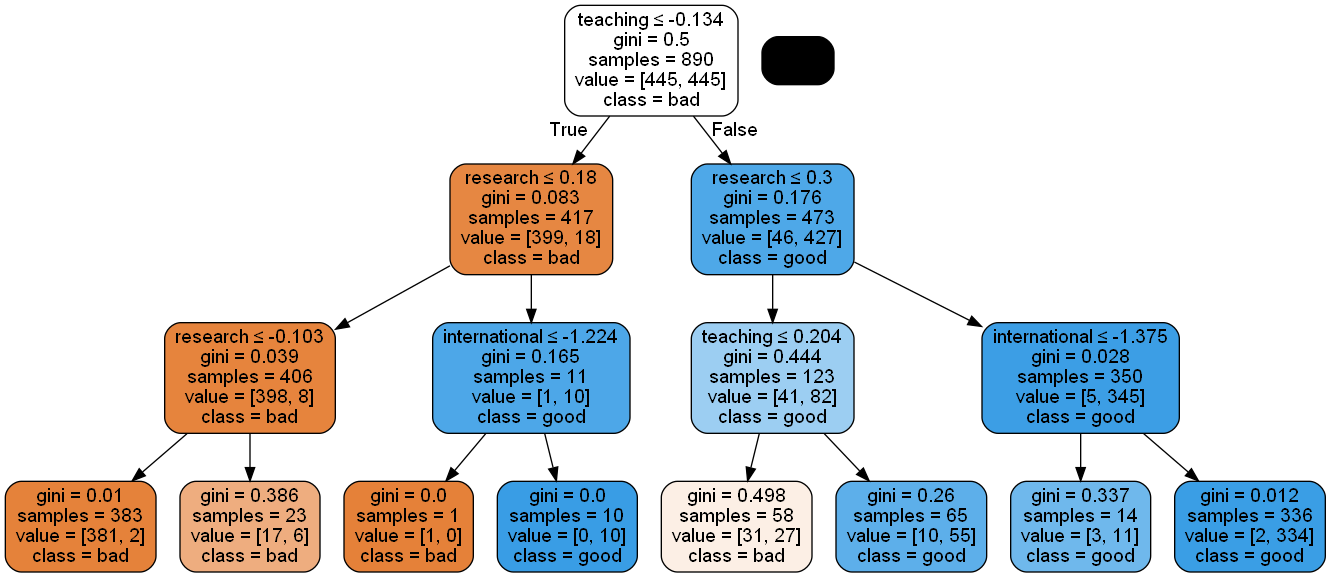

In [15]:
from sklearn.tree import export_graphviz
import pydotplus
import graphviz
from IPython.display import Image
dot_data = export_graphviz(tree, out_file=None,
feature_names=cols, class_names=["bad","good"],
filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

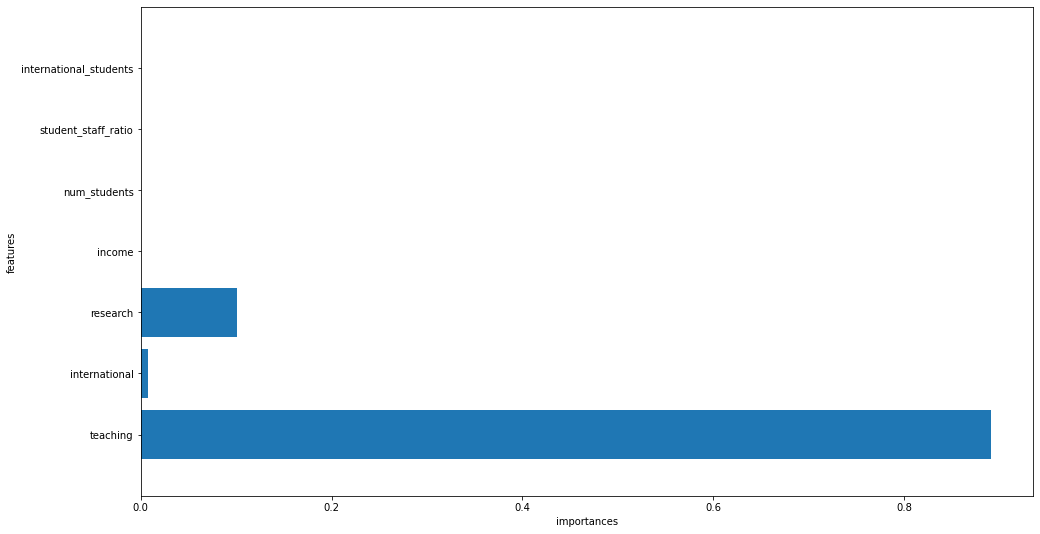

In [16]:
#트리를 만드는 결정에 각 특성이 얼마나 중요한지를 평가하는 특성 중요도 적용
#0~1 (0 ~ 1 사이의 값 전혀 사용되지 않음 완벽하게 타겟 클래스 예측)
import numpy as np
import matplotlib.pyplot as plt
def plot_tree(model):
    n_features = X.shape[1]
    plt.rcParams["figure.figsize"]=(16,9)
    plt.barh(range(n_features), model.feature_importances_,
    align='center')
    plt.yticks(np.arange(n_features), cols)
    plt.xlabel("importances")
    plt.ylabel("features")
    plt.ylim(-1, n_features)
plot_tree(tree)
# : teaching > research

In [17]:
#랜덤포레스트
from sklearn.ensemble import RandomForestClassifier
pipe = Pipeline([('scaler', StandardScaler()),
('clf', RandomForestClassifier(random_state=0)),])
params = {
'clf__max_depth': list(range(3,6)),
'clf__n_estimators': list(range(10,110,10)),
}
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

{'clf__max_depth': 4, 'clf__n_estimators': 20}
0.7918259168259167


In [18]:
scores.append(grid.best_score_)
scores

[0.9156770406770406, 0.7817135317135318, 0.7918259168259167]

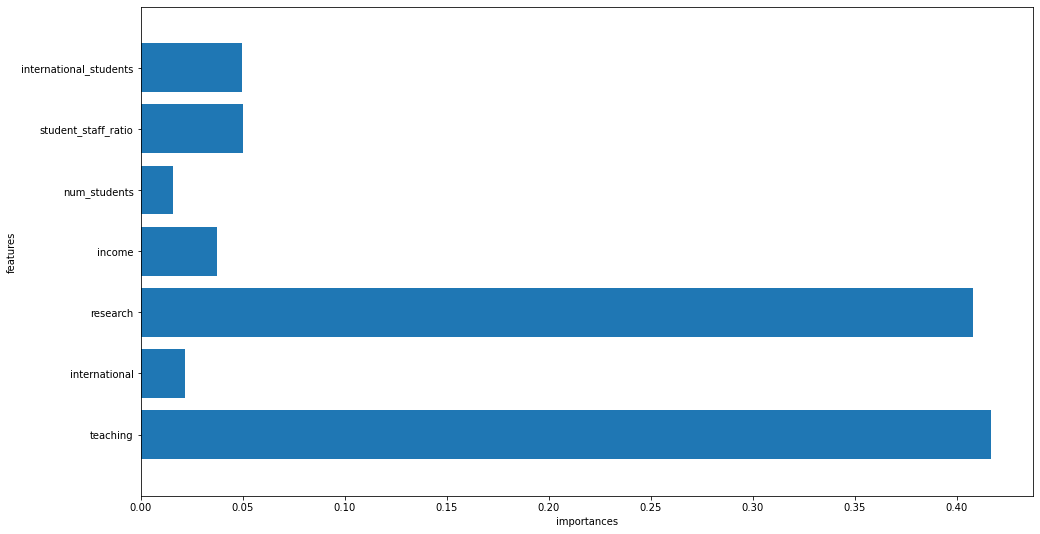

In [19]:
rf=grid.best_estimator_['clf']
plot_tree(rf)
# teaching > research

In [20]:
#knn
from sklearn.neighbors import KNeighborsClassifier
pipe = Pipeline([
('scaler', StandardScaler()),
('clf', KNeighborsClassifier()),
])
params = {
'clf__n_neighbors': list(range(1,11)),
}
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)


{'clf__n_neighbors': 9}
0.8280401613734947


In [21]:
scores.append(grid.best_score_)
scores

[0.9156770406770406,
 0.7817135317135318,
 0.7918259168259167,
 0.8280401613734947]

In [22]:
#인공신경망
from sklearn.neural_network import MLPClassifier
pipe = Pipeline([
('scaler', StandardScaler()),
('clf', MLPClassifier(random_state=0, max_iter=5000)),
])
params = {
'clf__hidden_layer_sizes': [(50,), (100,), (50,50), (100,100)],
'clf__activation': ['tanh', 'relu'],
'clf__alpha': [0.001, 0.01, 0.1]
}
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)


{'clf__activation': 'tanh', 'clf__alpha': 0.1, 'clf__hidden_layer_sizes': (100,)}
0.9100539933873266


In [23]:
scores.append(grid.best_score_)
scores

[0.9156770406770406,
 0.7817135317135318,
 0.7918259168259167,
 0.8280401613734947,
 0.9100539933873266]

In [24]:
#svm
from sklearn.svm import SVC
pipe = Pipeline([
('scaler', StandardScaler()),
('clf', SVC(random_state=0)),
])
params = {
'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
'clf__gamma': [0.0001, 0.001, 0.01, 0.1]
}
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)


{'clf__C': 1000, 'clf__gamma': 0.0001}
0.9111725361725362


In [25]:
scores.append(grid.best_score_)
scores

[0.9156770406770406,
 0.7817135317135318,
 0.7918259168259167,
 0.8280401613734947,
 0.9100539933873266,
 0.9111725361725362]

['LOGIT', 'Tree', 'RF', 'KNN', 'ANN', 'SVM']
[0.91567704 0.78171353 0.79182592 0.82804016 0.91005399 0.91117254]
 최적의 알고리즘: LOGIT
 최적의 정확도: 0.9156770406770406


Text(0, 0.5, 'Accuracy')

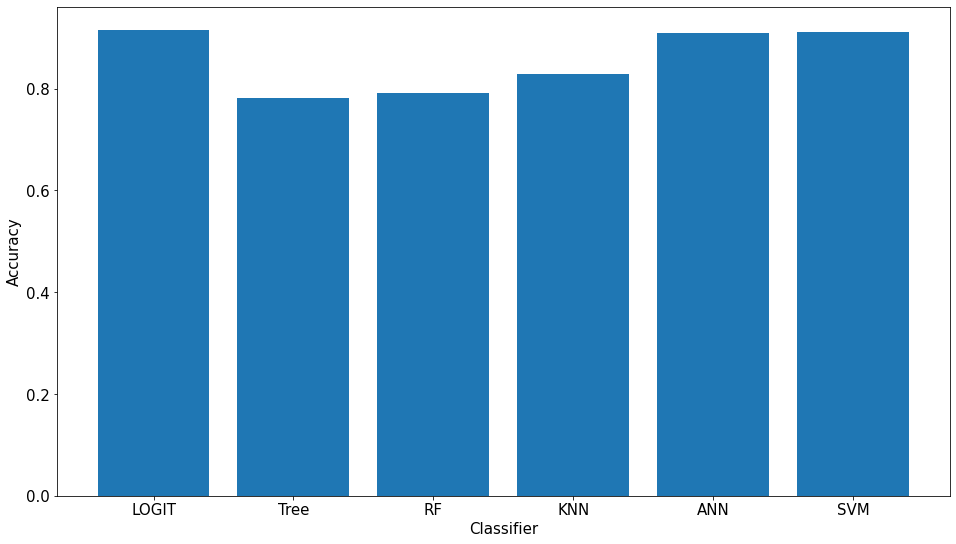

In [26]:
#알고리즘별 예측도 그래프
methods=["LOGIT","Tree","RF","KNN","ANN","SVM"]
scores_arr=np.array(scores) #검증용 데이터셋의 정확도
max_rate=np.max(scores_arr) #가장 좋은 정확도
idx=np.argmax(scores_arr) #최대값의 인덱스
print(methods)
print(scores_arr)
print(" 최적의 알고리즘:",methods[idx])
print(" 최적의 정확도:",max_rate) 
plt.rcParams["font.size"]=15
plt.bar(methods, scores_arr)
plt.xlabel("Classifier")
plt.ylabel("Accuracy")